<a href="https://colab.research.google.com/github/SANJAY729/Decision_Tree/blob/master/allo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("allo testing dhar")

allo testing dhar


In [ ]:
#hello123

In [15]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import copy

In [16]:
#The Pog Code






###################



def entropy(target_col):
    """
    Calculate the entropy of a dataset.
    The only parameter of this function is the target_col parameter which specifies the target column
    """
    elements,counts = np.unique(target_col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy


################### 
    
###################


def InfoGain(data,split_attribute_name,target_name="class"):
    """
    Calculate the information gain of a dataset. This function takes three parameters:
    1. data = The dataset for whose feature the IG should be calculated
    2. split_attribute_name = the name of the feature for which the information gain should be calculated
    3. target_name = the name of the target feature. The default for this example is "class"
    """    
    #Calculate the entropy of the total dataset
    total_entropy = entropy(data[target_name])
    
    ##Calculate the entropy of the dataset
    
    #Calculate the values and the corresponding counts for the split attribute 
    vals,counts= np.unique(data[split_attribute_name],return_counts=True)
    
    #Calculate the weighted entropy
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
    
    #Calculate the information gain
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain
       
###################

###################


def ID3(data,originaldata,features,max_depth,target_attribute_name="class",parent_node_class = None):
    """
    ID3 Algorithm: This function takes five paramters:
    1. data = the data for which the ID3 algorithm should be run --> In the first run this equals the total dataset
 
    2. originaldata = This is the original dataset needed to calculate the mode target feature value of the original dataset
    in the case the dataset delivered by the first parameter is empty

    3. features = the feature space of the dataset . This is needed for the recursive call since during the tree growing process
    we have to remove features from our dataset --> Splitting at each node

    4. target_attribute_name = the name of the target attribute

    5. parent_node_class = This is the value or class of the mode target feature value of the parent node for a specific node. This is 
    also needed for the recursive call since if the splitting leads to a situation that there are no more features left in the feature
    space, we want to return the mode target feature value of the direct parent node.
    """   
    #Define the stopping criteria --> If one of this is satisfied, we want to return a leaf node#
    # print(features)
    # print(data[target_attribute_name])
    #If all target_values have the same value, return this value
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    
    #If the dataset is empty, return the mode target feature value in the original dataset
    elif len(data) == 0:
        return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],return_counts=True)[1])]
    
    #If the feature space is empty, return the mode target feature value of the direct parent node --> Note that
    #the direct parent node is that node which has called the current run of the ID3 algorithm and hence
    #the mode target feature value is stored in the parent_node_class variable.
    
    elif len(features) == 0 or max_depth == 0:
        return parent_node_class
    
    #If none of the above holds true, grow the tree!
    else:
        #Set the default value for this node --> The mode target feature value of the current node
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],return_counts=True)[1])]
        
        #Select the feature which best splits the dataset
        item_values = [InfoGain(data,feature,target_attribute_name) for feature in features] #Return the information gain values for the features in the dataset
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        
        #Create the tree structure. The root gets the name of the feature (best_feature) with the maximum information
        #gain in the first run
        tree = {best_feature:{},"recurrence-events":0,"no-recurrence-events":0}
        
        
        #Remove the feature with the best inforamtion gain from the feature space
        features = [i for i in features if i != best_feature]
        
        #Grow a branch under the root node for each possible value of the root node feature
        
        for value in np.unique(data[best_feature]):
            value = value
            #Split the dataset along the value of the feature with the largest information gain and therwith create sub_datasets
            sub_data = data.where(data[best_feature] == value).dropna()
            
            #Call the ID3 algorithm for each of those sub_datasets with the new parameters --> Here the recursion comes in!
            subtree = ID3(sub_data,dataset,features,max_depth-1,target_attribute_name,parent_node_class)
            
            #Add the sub tree, grown from the sub_dataset to the tree under the root node
            tree[best_feature][value] = subtree
            
        return(tree)    
                
###################

###################


    
    
def predict(query,tree):
    """
    Prediction of a new/unseen query instance. This takes two parameters:
    1. The query instance as a dictionary of the shape {"feature_name":feature_value,...}

    2. The tree 


    We do this also in a recursive manner. That is, we wander down the tree and check if we have reached a leaf or if we are still in a sub tree. 
    Since this is a important step to understand, the single steps are extensively commented below.

    1.Check for every feature in the query instance if this feature is existing in the tree.keys() for the first call, 
    tree.keys() only contains the value for the root node 
    --> if this value is not existing, we can not make a prediction and have to 
    return the default value which is the majority value of the target feature

    2. First of all we have to take care of a important fact: Since we train our model with a database A and then show our model
    a unseen query it may happen that the feature values of these query are not existing in our tree model because non of the
    training instances has had such a value for this specific feature. 
    For instance imagine the situation where your model has only seen animals with one to four
    legs - The "legs" node in your model will only have four outgoing branches (from one to four). If you now show your model
    a new instance (animal) which has for the legs feature the vale 5, you have to tell your model what to do in such a 
    situation because otherwise there is no classification possible because in the classification step you try to 
    run down the outgoing branch with the value 5 but there is no such a branch. Hence: Error and no Classification!
    We can address this issue with a classification value of for instance (999) which tells us that there is no classification
    possible or we assign the most frequent target feature value of our dataset used to train the model. Or, in for instance 
    medical application we can return the most worse case - just to make sure... 
    We can also return the most frequent value of the direct parent node. To make a long story short, we have to tell the model 
    what to do in this situation.
    In our example, since we are dealing with animal species where a false classification is not that critical, we will assign
    the value 1 which is the value for the mammal species (for convenience).

    3. Address the key in the tree which fits the value for key --> Note that key == the features in the query. 
    Because we want the tree to predict the value which is hidden under the key value (imagine you have a drawn tree model on 
    the table in front of you and you have a query instance for which you want to predict the target feature 
    - What are you doing? - Correct:
    You start at the root node and wander down the tree comparing your query to the node values. Hence you want to have the
    value which is hidden under the current node. If this is a leaf, perfect, otherwise you wander the tree deeper until you
    get to a leaf node. 
    Though, you want to have this "something" [either leaf or sub_tree] which is hidden under the current node
    and hence we must address the node in the tree which == the key value from our query instance. 
    This is done with tree[keys]. Next you want to run down the branch of this node which is equal to the value given "behind"
    the key value of your query instance e.g. if you find "legs" == to tree.keys() that is, for the first run == the root node.
    You want to run deeper and therefore you have to address the branch at your node whose value is == to the value behind key.
    This is done with query[key] e.g. query[key] == query['legs'] == 0 --> Therewith we run down the branch of the node with the
    value 0. Summarized, in this step we want to address the node which is hidden behind a specific branch of the root node (in the first run)
    this is done with: result = [key][query[key]]

    4. As said in the 2. step, we run down the tree along nodes and branches until we get to a leaf node.
    That is, if result = tree[key][query[key]] returns another tree object (we have represented this by a dict object --> 
    that is if result is a dict object) we know that we have not arrived at a root node and have to run deeper the tree. 
    Okay... Look at your drawn tree in front of you... what are you doing?...well, you run down the next branch... 
    exactly as we have done it above with the slight difference that we already have passed a node and therewith 
    have to run only a fraction of the tree --> You clever guy! That "fraction of the tree" is exactly what we have stored
    under 'result'.
    So we simply call our predict method using the same query instance (we do not have to drop any features from the query
    instance since for instance the feature for the root node will not be available in any of the deeper sub_trees and hence 
    we will simply not find that feature) as well as the "reduced / sub_tree" stored in result.

    SUMMARIZED: If we have a query instance consisting of values for features, we take this features and check if the 
    name of the root node is equal to one of the query features.
    If this is true, we run down the root node outgoing branch whose value equals the value of query feature == the root node.
    If we find at the end of this branch a leaf node (not a dict object) we return this value (this is our prediction).
    If we instead find another node (== sub_tree == dict objct) we search in our query for the feature which equals the value 
    of that node. Next we look up the value of our query feature and run down the branch whose value is equal to the 
    query[key] == query feature value. And as you can see this is exactly the recursion we talked about
    with the important fact that for each node we run down the tree, we check only the nodes and branches which are 
    below this node and do not run the whole tree beginning at the root node 
    --> This is why we re-call the classification function with 'result'
    """
    
    default = "no-recurrence-events"
    if (tree["recurrence-events"]>tree["no-recurrence-events"]):
        default = "recurrence-events"
    for key in list(query.keys()):
        if key in list(tree.keys()):
            #2.
            try:
                result = tree[key][query[key]] 
            except:
                return default
  
            #3.
            result = tree[key][query[key]]
            #4.
            if isinstance(result,dict):
                return predict(query,result)

            else:
                return result

        
        
"""
Check the accuracy of our prediction.
The train_test_split function takes the dataset as parameter which should be divided into
a training and a testing set. The test function takes two parameters, which are the testing data as well as the tree model.
"""
###################

###################



def test(data,tree):
    #Create new query instances by simply removing the target feature column from the original dataset and 
    #convert it to a dictionary
    queries = data.iloc[:,1:].to_dict(orient = "records")
    
    #Create a empty DataFrame in whose columns the prediction of the tree are stored
    predicted = pd.DataFrame(columns=["predicted"]) 
    
    #Calculate the prediction accuracy
    for i in range(len(data)):
        predicted.loc[i,"predicted"] = predict(queries[i],tree)
    return (np.sum(predicted["predicted"] == data["class"])/len(data))*100
    #print('The prediction accuracy is: ',(np.sum(predicted["predicted"] == data["class"])/len(data))*100,'%')
    
def majorityclassutil(query,tree):
    if (query["class"]=="no-recurrence-events"):
        tree["no-recurrence-events"] = tree["no-recurrence-events"] + 1
    else:
        tree["recurrence-events"] = tree["recurrence-events"] + 1
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]] 
            except:
                return
            result = tree[key][query[key]]
            if isinstance(result,dict):
                return majorityclassutil(query,result)
            else:
                return
def majorityclasses(data,tree):
     queries = data.iloc[:,:-1].to_dict(orient = "records")
     for i in range(len(data)):
        majorityclassutil(queries[i],tree)






In [17]:
#Import the dataset and define the feature as well as the target datasets / columns#
dataset_init = pd.read_csv('breast-cancer.csv',
                      names=['class','age','menopause','tumor-size','inv-nodes','node-caps','def-malig','breast','breast-quad','irradiat'])#Import all columns omitting the fist which consists the names of the animals
# Class: no-recurrence-events, recurrence-events
# 2. age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99.
# 3. menopause: lt40, ge40, premeno.
# 4. tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59.
# 5. inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39.
# 6. node-caps: yes, no.
# 7. deg-malig: 1, 2, 3.
# 8. breast: left, right.
# 9. breast-quad: left-up, left-low, right-up, right-low, central.
# 10. irradiat: yes, no.


dataset_ = dataset_init[dataset_init['node-caps']!='?']
dataset = dataset_[dataset_['breast-quad']!='?']


In [18]:
def train_test_split(dataset):
    training_data = dataset.iloc[:230].reset_index(drop=True)#We drop the index respectively relabel the index
    #starting form 0, because we do not want to run into errors regarding the row labels / indexes
    testing_data = dataset.iloc[230:].reset_index(drop=True)
    return training_data,testing_data

<function matplotlib.pyplot.show>

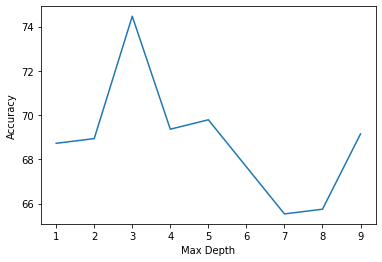

In [ ]:
"""
Train the tree, Print the tree and predict the accuracy
"""

x = [1,2,3,4,5,6,7,8,9]
y = []
for i in range (1,10):
    accuracy = 0
    for j in range(1,11):
        dataset = dataset.sample(frac=1).reset_index(drop=True)
        training_data,testing_data=train_test_split(dataset)
        tree = ID3(training_data,training_data,training_data.columns[1:],i)
        majorityclasses(training_data,tree)
        accuracy = accuracy + test(testing_data,tree)
    y.append(accuracy/10)
plt.plot(x,y)
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.show


In [19]:
#pruning
def train_validation_test_split(dataset):
    training_data = dataset.iloc[:180].reset_index(drop=True)
    validation_data = dataset.iloc[180:230].reset_index(drop=True)
    testing_data = dataset.iloc[230:].reset_index(drop=True)
    return training_data,validation_data,testing_data

# max_depth  = 3
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
# dataset = dataset.sample(frac=1).reset_index(drop=True)
# training_data,validation_data,testing_data = train_validation_test_split(dataset)
# tree = ID3(training_data,training_data,training_data.columns[1:],max_depth)
# majorityclasses(training_data,tree)
# initial_accuracy = test(validation_data,tree)
# #print(validation_data)
# print(initial_accuracy)
# pprint(tree)
# #def post_pruning(tree,initial_accuracy,validation_data):


In [22]:
def possiblevalues(keys):
    feature = ""
    values = []
    for key in keys:
        if (key == 'no-recurrence-events'):
            continue
        elif (key == 'recurrence-events'):
            continue
        else :
            feature = key
            if (feature == 'age'):
                values = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
            if (feature == 'menopause'):
                values = ['lt40', 'ge40', 'premeno']
            if (feature == 'tumor-size'):
                values = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59']
            if (feature == 'inv-nodes'):
                values = ['0-2', '3-5', '6-8', '9-11', '12-14', '15-17', '18-20', '21-23', '24-26', '27-29', '30-32', '33-35', '36-39']
            if (feature == 'node-caps'):
                values = ['yes', 'no']
            if (feature == 'deg-malig'):
                values = ['1', '2', '3']
            if (feature == 'breast'):
                values = ['left', 'right']
            if (feature == 'breast-quad'):
                values = ['left-up', 'left-low', 'right-up', 'right-low', 'central']
            if (feature == 'irradiat'):
                values = ['yes', 'no']            
    return feature,values

def skip():
  return
def delete_node(tree,node,target):
    if (node==tree):
        return target
    else:
        if isinstance(tree, dict):
            feature, values = possiblevalues(tree.keys())
            for value in values:
                try:
                    tree[feature][value] = copy.deepcopy(delete_node(tree[feature][value],node,target))
                except:
                    skip()
    return tree
def post_pruning(tree,initial_accuracy,validation_data):
    initial_tree = copy.deepcopy(tree)
    best_tree = copy.deepcopy(tree)
    current_tree = copy.deepcopy(tree)
    best_accuracy = initial_accuracy
    flag = 0
    queue = []
    node_removed=None
    queue.append(tree)
    while queue!=[]:
        node = queue.pop(0)
        if isinstance(node, dict):
            feature, values = possiblevalues(node.keys())
            for value in values:
                try:
                    queue.append(node[feature][value])
                    
                except:
                    skip()
            if node==initial_tree :
                print('hello')
                continue
            
            if node['no-recurrence-events']>node['recurrence-events']:
                current_tree=copy.deepcopy(delete_node(initial_tree,node,'no-recurrence-events'))
            else :
                current_tree=copy.deepcopy(delete_node(initial_tree,node,'recurrence-events'))
            initial_tree = copy.deepcopy(tree)
            #print(current_tree)
            current_accuracy = test(validation_data,current_tree)
            if current_accuracy>best_accuracy:
                flag = 1
                best_tree = copy.deepcopy(current_tree)
                node_removed = node
                best_accuracy = current_accuracy    
    return best_tree,node_removed,best_accuracy,flag

In [30]:
max_depth  = 3
pd.options.display.max_columns = None
pd.options.display.max_rows = None
dataset = dataset.sample(frac=1).reset_index(drop=True)
training_data,validation_data,testing_data = train_validation_test_split(dataset)
tree = ID3(training_data,training_data,training_data.columns[1:],max_depth)
majorityclasses(training_data,tree)
initial_accuracy = test(validation_data,tree)
#print(validation_data)
print('validation data initial acc',initial_accuracy)
#pprint(tree)
ini_tree=copy.deepcopy(tree)
best_tree,node_removed,best_accuracy,flag=post_pruning(tree,initial_accuracy,validation_data)
print('validation data after 1 prune acc',best_accuracy)
print('testing accuracy before prune',test(testing_data,ini_tree))
print('testing accuracy after prune',test(testing_data,best_tree))
#print(flag,best_accuracy)
#pprint(node_removed)
#pprint(best_tree)
#pprint(ini_tree)

validation data initial acc 74.0
hello
validation data after 1 prune acc 78.0
testing accuracy before prune 78.72340425531915
testing accuracy after prune 74.46808510638297
